In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer, Dense, Input, LeakyReLU, Reshape
from tensorflow.keras.layers import UpSampling2D, AveragePooling2D, Flatten
from tensorflow.keras.activations import relu, tanh
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.constraints import max_norm
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from glob import glob
from functools import partial
import time

import warnings
warnings.filterwarnings('ignore')
print("Tensorflow", tf.__version__)
from packaging.version import parse as parse_version
assert parse_version(tf.__version__) < parse_version("2.4.0"), \
    f"Please install TensorFlow version 2.3.1 or older. Your current version is {tf.__version__}."

Tensorflow 2.2.0


You can download celeba_hq dataset from
https://www.kaggle.com/lamsimon/celebahq or run the cell below

In [ ]:
url = "https://drive.google.com/uc?id=17w_hePC1xO2eX83gAAF8ptKC59mTPQiL" 
gdown.download(url, 'celeba_hq.zip', quiet=False)
!unzip celeba_hq.zip -d ./celeba_hq

In [3]:
PATH = "celeba_hq/"
BUFFER_SIZE = 200
IMAGE_RESOLUTION = 256

def load(res, image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, [res, res],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.cast(image, tf.float32)
    image = (image /127.5) - 1
    return image
        
train_datasets = {}
train_images = glob(PATH+'train/**/*.jpg')
random.shuffle(train_images)
train_dataset_list = tf.data.Dataset.from_tensor_slices(train_images)

n_workers = tf.data.experimental.AUTOTUNE
BATCH_SIZE = {2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 8, 8: 4, 9: 4, 10:4}
TRAIN_STEP_RATIO = {k: BATCH_SIZE[2]/v for k, v in BATCH_SIZE.items()}
for log2_res in range(2, int(np.log2(IMAGE_RESOLUTION))+1):
    res = 2**log2_res
    temp = train_dataset_list.map(partial(load, res),  num_parallel_calls= n_workers)

    temp = temp.shuffle(BUFFER_SIZE).batch(BATCH_SIZE[log2_res], drop_remainder=True).repeat()
    train_datasets[log2_res] = temp

In [4]:
def plot_images(images, log2_res, fname=''):    
    scales = {2:0.5,
             3:1,
             4:2,
             5:3,
             6:4,
             7:5,
             8:6,
             9:7,
             10:8}
    scale = scales[log2_res]
    
    grid_col = min(12, int(12//scale))
    grid_row = images.shape[0]//grid_col
    grid_row = min(2, grid_row)

    f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*scale, grid_row*scale))

    for row in range(grid_row):
        ax = axarr if grid_row==1 else axarr[row]
        for col in range(grid_col):
            ax[col].imshow(images[row*grid_col + col])
            ax[col].axis('off')
    plt.show()
    if fname:
        print("image name", fname)
        f.savefig(fname)

In [5]:
class PixelNorm(Layer):
    def __init__(self, epsilon=1e-8):
        super(PixelNorm, self).__init__()
        self.epsilon = epsilon
        
    def call(self, input_tensor):
        return input_tensor / tf.math.sqrt(tf.reduce_mean(input_tensor**2, axis=-1, keepdims=True) + self.epsilon)

class MinibatchStd(Layer): 
    def __init__(self, group_size=4, epsilon=1e-8): 

        super(MinibatchStd, self).__init__() 
        self.epsilon = epsilon 
        self.group_size = group_size 
        
    def call(self, input_tensor): 

        n, h, w, c = input_tensor.shape 
        x = tf.reshape(input_tensor, [self.group_size, -1, h, w, c]) 
        group_mean, group_var = tf.nn.moments(x, axes=(0), keepdims=False) 
        group_std = tf.sqrt(group_var + self.epsilon) 
        avg_std = tf.reduce_mean(group_std, axis=[1,2,3], keepdims=True) 
        x = tf.tile(avg_std, [self.group_size, h, w, 1]) 

        return tf.concat([input_tensor, x], axis=-1) 
    
class FadeIn(Layer):
    @tf.function
    def call(self, input_alpha, a, b):
        alpha = tf.reduce_mean(input_alpha)
        y = alpha * a + (1. - alpha) * b
        return y
    
def wasserstein_loss(y_true, y_pred):
    
    return -tf.reduce_mean(y_true * y_pred)



In [6]:
class Conv2D(Layer):
    def __init__(self, out_channels, kernel=3, gain=2, **kwargs):
        super(Conv2D, self).__init__(kwargs)
        self.kernel = kernel
        self.out_channels = out_channels
        self.gain = gain
        self.pad = kernel!=1
        
    def build(self, input_shape):
        self.in_channels = input_shape[-1]

        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)        
        self.w = self.add_weight(shape=[self.kernel,
                                        self.kernel,
                                        self.in_channels,
                                        self.out_channels],
                                initializer=initializer,
                                trainable=True, name='kernel')
        
        self.b = self.add_weight(shape=(self.out_channels,),
                                initializer='zeros',
                                trainable=True, name='bias')
        
        fan_in = self.kernel*self.kernel*self.in_channels
        self.scale = tf.sqrt(self.gain/fan_in)
        
    def call(self, inputs):
        if self.pad:
            x = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        else:
            x = inputs
        output = tf.nn.conv2d(x, self.scale*self.w, strides=1, padding="VALID") + self.b
        return output
    
class Dense(Layer):
    def __init__(self, units, gain=2, **kwargs):
        super(Dense, self).__init__(kwargs)
        self.units = units
        self.gain = gain
        
    def build(self, input_shape):
        self.in_channels = input_shape[-1]
        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)        
        self.w = self.add_weight(shape=[self.in_channels,
                                        self.units],
                                initializer=initializer,
                                trainable=True, name='kernel')
        
        self.b = self.add_weight(shape=(self.units,),
                                initializer='zeros',
                                trainable=True, name='bias')
        
        fan_in = self.in_channels
        self.scale = tf.sqrt(self.gain/fan_in)
        
    #@tf.function
    def call(self, inputs):
        output = tf.matmul(inputs, self.scale*self.w) + self.b
        return output
    

In [12]:
class ProgressiveGAN():
    def __init__(self, z_dim=512, resolution=512, load_path=None, start_log2_res=2):
        self.start_log2_res = start_log2_res
        self.resolution = resolution
        self.log2_resolution = int(np.log2(resolution))
        self.log2_res_to_filter_size = {
            0: 512,
            1: 512,
            2: 512, # 4x4
            3: 512, # 8x8
            4: 512, # 16x16
            5: 512, # 32x32
            6: 256, # 64x64
            7: 128, # 128x128
            8: 64,  # 256x256
            9: 32,  # 512x512
            10: 16} # 1024x1024 

        self.z_dim = z_dim
        self.initializer = tf.keras.initializers.RandomNormal(0., 1.)
        self.opt_init = {'learning_rate':1e-3, 'beta_1':0.0, 'beta_2':0.99, 'epsilon':1e-8}

        self.g_loss = 0.
        self.d_loss = 0.
        self.build_all_generators()
        self.build_all_discriminators()

        if load_path:
            self.load_checkpoint(load_path)

        # initialize generator with the base
        dummy_alpha = Input(shape=(1), name='DummyAlpha')
        rgb  = self.to_rgb[2](self.generator_blocks[2].output)
        self.generator = Model([self.generator_blocks[2].input, dummy_alpha], rgb)

        # build base discriminator
        input_image = Input(shape=(4,4,3))
        alpha = Input(shape=(1))           
        x = self.from_rgb[2](input_image)  
        pred = self.discriminator_blocks[2](x)

        self.discriminator = Model([input_image, alpha], pred,
                                    name='discriminator_4x4')

        self.optimizer_discriminator = Adam(**self.opt_init)                

        self.discriminator.trainable = False

        # build composite model
        pred = self.discriminator([self.generator.output, self.generator.input[1]])

        self.model = Model(inputs=self.generator.input,
                          outputs=pred)
        self.model.compile(loss=wasserstein_loss, optimizer=Adam(**self.opt_init))

        checkpoint_path = f"./checkpoints/"
        self.ckpt = tf.train.Checkpoint(generator = self.generator,
                                       discriminator = self.discriminator)
        self.ckpt_manager = tf.train.CheckpointManager(self.ckpt, checkpoint_path, max_to_keep=40)

            
    def load_checkpoint(self, ckpt_path):
        self.grow_model(self.start_log2_res)
        self.ckpt.restore(ckpt_path)
        
    def build_all_generators(self):
        # build all the generator block
        self.to_rgb = {}
        self.generator_blocks = {}
        self.generator_blocks[2] = self.build_generator_base(self.z_dim)
        self.to_rgb[2] = self.build_to_rgb(4, self.log2_res_to_filter_size[2])
        
        for log2_res in range(3, self.log2_resolution+1):
            res = 2**log2_res
            filter_n = self.log2_res_to_filter_size[log2_res]            
            self.to_rgb[log2_res] = self.build_to_rgb(res, filter_n)

            input_shape = self.generator_blocks[log2_res-1].output[0].shape
            gen_block = self.build_generator_block(log2_res, input_shape)
            self.generator_blocks[log2_res] = gen_block
        

    def build_generator_base(self, input_shape):
        
        input_tensor = Input(shape=input_shape)
        x = PixelNorm()(input_tensor)
        x = Dense(8192, gain=1./8)(x)
        x = Reshape((4, 4, 512))(x)
        x = LeakyReLU(0.2)(x)        
        x = PixelNorm()(x)
        
        x = Conv2D(512, 3, 
                   name='gen_4x4_conv1')(x)
        x = LeakyReLU(0.2)(x)
        x = PixelNorm()(x)
        
        return Model(input_tensor, x, 
                     name='generator_base') 

    def build_generator_block(self, log2_res, input_shape):
        res = 2**log2_res
        res_name = f'{res}x{res}'
        filter_n = self.log2_res_to_filter_size[log2_res]
        
        input_tensor = Input(shape=input_shape)
        x = UpSampling2D((2,2))(input_tensor)
                
        x = Conv2D(filter_n, 3, name=f'gen_{res_name}_conv1')(x)
        x = LeakyReLU(0.2)(x)
        x = PixelNorm()(x)
        
        x = Conv2D(filter_n, 3, name=f'gen_{res_name}_conv2')(x)
        x = LeakyReLU(0.2)(x)
        x = PixelNorm()(x)      
        
        return Model(input_tensor, x, 
                     name=f'genblock_{res}_x_{res}') 


        
    def build_discriminator_block(self, log2_res, input_shape):

        filter_n = self.log2_res_to_filter_size[log2_res]        
        input_tensor = Input(shape=input_shape)
        
        # First conv
        x = Conv2D(filter_n, 3)(input_tensor)
        x = LeakyReLU(0.2)(x)
        
        # Second conv + downsample
        filter_n = self.log2_res_to_filter_size[log2_res-1]        
        x = Conv2D(filter_n, 3,)(x)
        x = LeakyReLU(0.2)(x)
        x = AveragePooling2D((2,2))(x)
        
        res = 2**log2_res
        return Model(input_tensor, x, 
                     name=f'disc_block_{res}_x_{res}') 
        
        
    def build_discriminator_base(self, input_shape):

        input_tensor = Input(shape=input_shape)

        x = MinibatchStd()(input_tensor)
        #x = input_tensor
        x = Conv2D(512, 3, name='gen_4x4_conv1')(x)
        x = LeakyReLU(0.2)(x)
        x = Flatten()(x)
        
        x = Dense(512, name='gen_4x4_dense1')(x)
        x = LeakyReLU(0.2)(x)

        x = Dense(1, name='gen_4x4_dense2')(x)
        
        return Model(input_tensor, x, 
                     name='discriminator_base') 

    def build_to_rgb(self, res, filter_n):
        
        return Sequential([Input(shape=(res, res, filter_n)),
                           Conv2D(3, 1, gain=1, activation=None,
                                  name=f'to_rgb_{res}x{res}_conv')],
                         name=f'to_rgb_{res}x{res}')
    
    def build_from_rgb(self, res, filter_n):
        
        return Sequential([Input(shape=(res, res, 3)),
                           Conv2D(filter_n, 1,
                                  name=f'from_rgb_{res}x{res}_conv'),
                           LeakyReLU(0.2)],
                         name=f'from_rgb_{res}x{res}')
    
    def build_all_discriminators(self):
        
        self.from_rgb = {}
        self.discriminator_blocks = {}
        
        # all but the final block
        for log2_res in range(self.log2_resolution, 1, -1):
            res = 2**log2_res
            filter_n = self.log2_res_to_filter_size[log2_res]            
            self.from_rgb[log2_res] = self.build_from_rgb(res, filter_n)
            
            input_shape = (res, res, filter_n)
            self.discriminator_blocks[log2_res] = self.build_discriminator_block(log2_res, input_shape)

        # last block at 4x4 resolution
        log2_res = 2
        filter_n = self.log2_res_to_filter_size[log2_res]            
        self.from_rgb[log2_res] = self.build_from_rgb(4, filter_n)
        res = 2**log2_res
        input_shape = (res, res, filter_n)            
        self.discriminator_blocks[log2_res] = self.build_discriminator_base(input_shape)
                                       
        

        
    def grow_discriminator(self, log2_res):
        res = 2**log2_res 

        input_image = Input(shape=(res, res, 3))
        alpha = Input(shape=(1))
        
        x = self.from_rgb[log2_res](input_image)
        x = self.discriminator_blocks[log2_res](x)        
        
        downsized_image = AveragePooling2D((2,2))(input_image)
        y = self.from_rgb[log2_res-1](downsized_image)
        
        x = FadeIn()(alpha, x, y)
        for i in range (log2_res-1, 1, -1):
            x = self.discriminator_blocks[i](x)
            
        self.discriminator =  Model([input_image, alpha], x,
                     name=f'discriminator_{res}_x_{res}')
        
        self.optimizer_discriminator = Adam(**self.opt_init)        
                
    def grow_generator(self, log2_res):
        res = 2**log2_res
        alpha = Input(shape=(1))
        
        x = self.generator_blocks[2].input

        for i in range(2, log2_res):            
            x = self.generator_blocks[i](x)
        
        old_rgb = self.to_rgb[log2_res-1](x)
        old_rgb = UpSampling2D((2,2))(old_rgb)
        
        x = self.generator_blocks[log2_res](x)
        new_rgb = self.to_rgb[log2_res](x)
        rgb = FadeIn()(alpha, new_rgb, old_rgb)
        self.generator = Model([self.generator_blocks[2].input, alpha], 
                               rgb, 
                        name=f'generator_{res}_x_{res}')         
                         
    def grow_model(self, log2_res):
        tf.keras.backend.clear_session()
        res = 2**log2_res
        print(f"Growing model to {res}x{res}")
            
        self.grow_generator(log2_res)
        self.grow_discriminator(log2_res)

        self.discriminator.trainable = False

        latent_input = Input(shape=(self.z_dim))
        alpha_input = Input(shape=(1))
        fake_image = self.generator([latent_input, alpha_input])
        pred = self.discriminator([fake_image, alpha_input])

        self.model = Model(inputs=[latent_input, alpha_input],
                          outputs=pred)
        self.model.compile(loss=wasserstein_loss, 
                           optimizer=Adam(**self.opt_init))
    
    def train_discriminator_wgan_gp(self, real_images, alpha):
        
        batch_size = real_images.shape[0]
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)
        
        z = tf.random.normal((batch_size, self.z_dim))        
        fake_images = self.generator([z, alpha])
        
        
        with tf.GradientTape() as gradient_tape,\
             tf.GradientTape() as total_tape:
            
            # forward pass
            pred_fake = self.discriminator([fake_images, alpha])
            pred_real = self.discriminator([real_images, alpha])
                  
            epsilon = tf.random.uniform((batch_size,1,1,1))
            interpolates = epsilon*real_images + (1-epsilon)*fake_images
            gradient_tape.watch(interpolates)
            pred_fake_grad = self.discriminator([interpolates, alpha])
            
            # calculate losses
            loss_fake = wasserstein_loss(fake_labels, pred_fake)
            loss_real = wasserstein_loss(real_labels, pred_real)
            loss_fake_grad = wasserstein_loss(fake_labels, pred_fake_grad)
            
            
            # gradient penalty      
            gradients_fake = gradient_tape.gradient(loss_fake_grad, [interpolates])
            gradient_penalty = self.gradient_loss(gradients_fake)
     
            # drift loss
            all_pred = tf.concat([pred_fake, pred_real], axis=0)
            drift_loss = 0.001 * tf.reduce_mean(all_pred**2)
            
            total_loss = loss_fake + loss_real + gradient_penalty + drift_loss
            
            # apply gradients
            gradients = total_tape.gradient(total_loss, self.discriminator.variables)
            
            self.optimizer_discriminator.apply_gradients(zip(gradients, self.discriminator.variables))


        return total_loss
    
    
    def train_step(self,  log2_res, data_gen, alpha):
        real_images = next(data_gen)
        self.d_loss = self.train_discriminator_wgan_gp(real_images, alpha)

        real_images = next(data_gen)
        batch_size = real_images.shape[0]
        real_labels = tf.ones(batch_size)
        z = tf.random.normal((batch_size, self.z_dim))
        self.g_loss = self.model.train_on_batch([z, alpha], real_labels)

    
    def generate(self, z):
        images = self.generator([z, self.alpha])
        images = np.clip((images*0.5 + 0.5)*255, 0, 255)
        return images.astype(np.uint8)
        
        
    def checkpoint(self, z, log2_res, step):
        res = 2**log2_res
        prefix = f'res_{res}x{res}_{step}'
        ckpt_save_path = self.ckpt_manager.save()
        print('Saving checkpoint',ckpt_save_path)
        
        images = self.generate(z)
        plot_images(images, log2_res, f"./save_images/{prefix}.jpg")
        
    def gradient_loss(self, grad):
        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=np.arange(1,len(loss.shape)))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss - 1))
        self.penalty_const = 10
        loss = self.penalty_const * loss
        return loss
    
    def train(self, datasets, steps_per_phase = 1000, tick_interval=500):
        self.val_z = tf.random.normal((12, self.z_dim))
        
        for log2_res in range(self.start_log2_res, self.log2_resolution+1, 1):
            start_time = time.time()
            self.current_log2_res = log2_res
            
            res = 2**log2_res
            data_gen = iter(datasets[log2_res])
            print(f"Resolution {res}x{res}")
            
            for state in ['TRANSITION','STABLE']:
                if state == 'TRANSITION' and log2_res == 2:
                    continue
                
                steps = int(TRAIN_STEP_RATIO[log2_res] * steps_per_phase)
                interval = int(TRAIN_STEP_RATIO[log2_res] * tick_interval)
                for step in range(0, steps):
                    alpha = step/steps if state == 'TRANSITION' else 1.
                    self.alpha = np.array([[alpha]])

                    if step%interval == 0:                        
                        print('alpha', self.alpha)
                        elapsed = time.time() - start_time
                        start_time = time.time()
                        minutes = int(elapsed//60)
                        seconds = int(elapsed%60)
                        print(f"elapsed {minutes} min {seconds} sec")
                        msg = f"{state}. Resolution {res}x{res} Step {step}: g_loss {self.g_loss:.4f} d_loss {self.d_loss:.4f}"
                        print(msg)

                        self.checkpoint(self.val_z, log2_res, step)

                    self.train_step(log2_res, data_gen, self.alpha)
                        
            if log2_res != self.log2_resolution:
                self.grow_model(log2_res+1)
            
gan = ProgressiveGAN(resolution=IMAGE_RESOLUTION)

# Training

Resolution 4x4
alpha [[1.]]
elapsed 0 min 0 sec
STABLE. Resolution 4x4 Step 0: g_loss 0.0000 d_loss 0.0000
Saving checkpoint ./checkpoints/ckpt-1


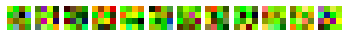

image name ./save_images/res_4x4_0.jpg
alpha [[1.]]
elapsed 2 min 43 sec
STABLE. Resolution 4x4 Step 4000: g_loss 3.1868 d_loss -3.4274
Saving checkpoint ./checkpoints/ckpt-2


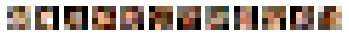

image name ./save_images/res_4x4_4000.jpg
alpha [[1.]]
elapsed 2 min 42 sec
STABLE. Resolution 4x4 Step 8000: g_loss 2.5993 d_loss -5.9495
Saving checkpoint ./checkpoints/ckpt-3


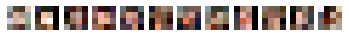

image name ./save_images/res_4x4_8000.jpg
alpha [[1.]]
elapsed 2 min 41 sec
STABLE. Resolution 4x4 Step 12000: g_loss 3.4653 d_loss -3.9043
Saving checkpoint ./checkpoints/ckpt-4


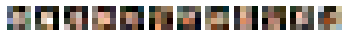

image name ./save_images/res_4x4_12000.jpg
alpha [[1.]]
elapsed 2 min 41 sec
STABLE. Resolution 4x4 Step 16000: g_loss 2.9252 d_loss -3.4300
Saving checkpoint ./checkpoints/ckpt-5


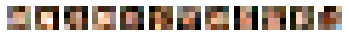

image name ./save_images/res_4x4_16000.jpg
Growing model to 256x256
Resolution 8x8
alpha [[0.]]
elapsed 0 min 0 sec
TRANSITION. Resolution 8x8 Step 0: g_loss 1.7195 d_loss -4.2954
Saving checkpoint ./checkpoints/ckpt-6


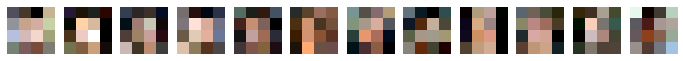

image name ./save_images/res_8x8_0.jpg
alpha [[0.2]]
elapsed 4 min 58 sec
TRANSITION. Resolution 8x8 Step 4000: g_loss -5.5354 d_loss -2.7139
Saving checkpoint ./checkpoints/ckpt-7


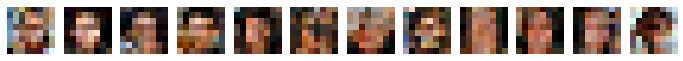

image name ./save_images/res_8x8_4000.jpg
alpha [[0.4]]
elapsed 4 min 56 sec
TRANSITION. Resolution 8x8 Step 8000: g_loss 0.0411 d_loss -3.7879
Saving checkpoint ./checkpoints/ckpt-8


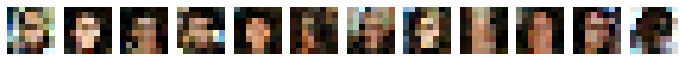

image name ./save_images/res_8x8_8000.jpg
alpha [[0.6]]
elapsed 4 min 59 sec
TRANSITION. Resolution 8x8 Step 12000: g_loss 3.0324 d_loss -3.0189
Saving checkpoint ./checkpoints/ckpt-9


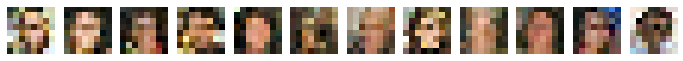

image name ./save_images/res_8x8_12000.jpg
alpha [[0.8]]
elapsed 4 min 58 sec
TRANSITION. Resolution 8x8 Step 16000: g_loss 2.3853 d_loss -2.4068
Saving checkpoint ./checkpoints/ckpt-10


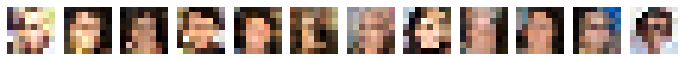

image name ./save_images/res_8x8_16000.jpg
alpha [[1.]]
elapsed 4 min 57 sec
STABLE. Resolution 8x8 Step 0: g_loss 0.9480 d_loss -1.7237
Saving checkpoint ./checkpoints/ckpt-11


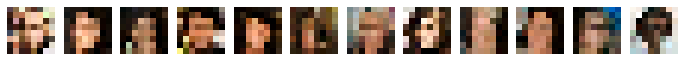

image name ./save_images/res_8x8_0.jpg
alpha [[1.]]
elapsed 4 min 57 sec
STABLE. Resolution 8x8 Step 4000: g_loss 3.3765 d_loss -0.2534
Saving checkpoint ./checkpoints/ckpt-12


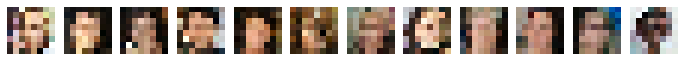

image name ./save_images/res_8x8_4000.jpg
alpha [[1.]]
elapsed 5 min 0 sec
STABLE. Resolution 8x8 Step 8000: g_loss -8.6872 d_loss -0.9566
Saving checkpoint ./checkpoints/ckpt-13


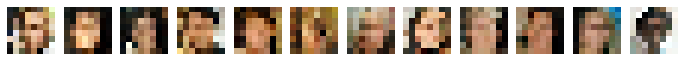

image name ./save_images/res_8x8_8000.jpg
alpha [[1.]]
elapsed 4 min 59 sec
STABLE. Resolution 8x8 Step 12000: g_loss -11.8138 d_loss 0.4740
Saving checkpoint ./checkpoints/ckpt-14


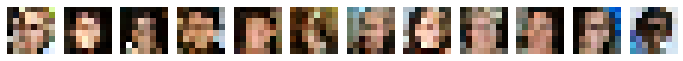

image name ./save_images/res_8x8_12000.jpg
alpha [[1.]]
elapsed 4 min 58 sec
STABLE. Resolution 8x8 Step 16000: g_loss 3.0927 d_loss -0.8237
Saving checkpoint ./checkpoints/ckpt-15


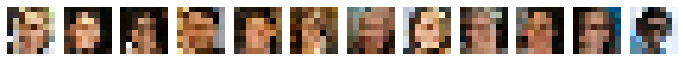

image name ./save_images/res_8x8_16000.jpg
Growing model to 256x256
Resolution 16x16
alpha [[0.]]
elapsed 0 min 0 sec
TRANSITION. Resolution 16x16 Step 0: g_loss -0.4766 d_loss -0.6272
Saving checkpoint ./checkpoints/ckpt-16


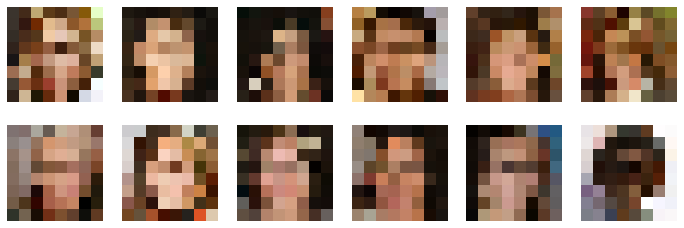

image name ./save_images/res_16x16_0.jpg
alpha [[0.2]]
elapsed 7 min 58 sec
TRANSITION. Resolution 16x16 Step 4000: g_loss 8.1020 d_loss 1.2967
Saving checkpoint ./checkpoints/ckpt-17


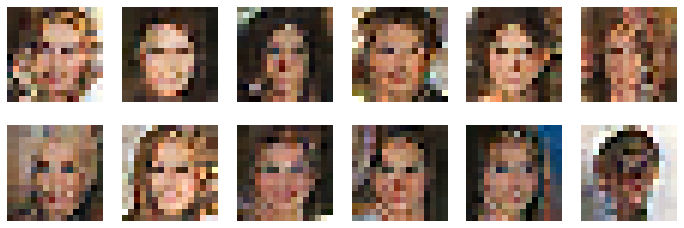

image name ./save_images/res_16x16_4000.jpg
alpha [[0.4]]
elapsed 7 min 56 sec
TRANSITION. Resolution 16x16 Step 8000: g_loss 2.2417 d_loss -0.7980
Saving checkpoint ./checkpoints/ckpt-18


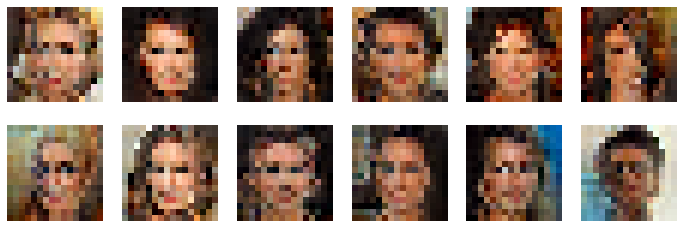

image name ./save_images/res_16x16_8000.jpg
alpha [[0.6]]
elapsed 7 min 57 sec
TRANSITION. Resolution 16x16 Step 12000: g_loss 3.5304 d_loss -0.2867
Saving checkpoint ./checkpoints/ckpt-19


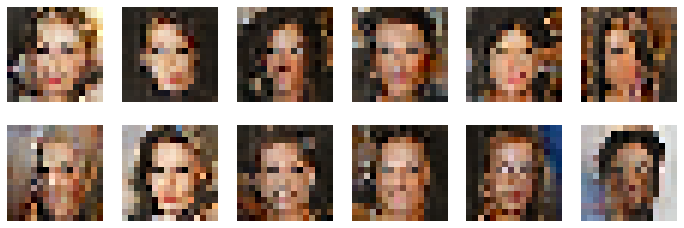

image name ./save_images/res_16x16_12000.jpg
alpha [[0.8]]
elapsed 7 min 57 sec
TRANSITION. Resolution 16x16 Step 16000: g_loss 19.2461 d_loss -7.5455
Saving checkpoint ./checkpoints/ckpt-20


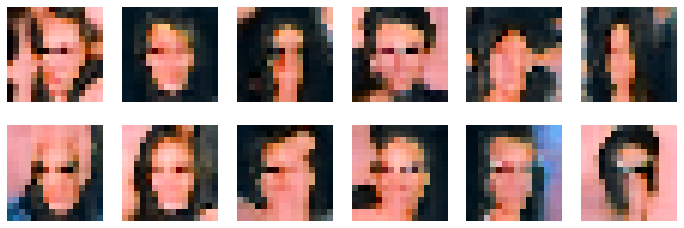

image name ./save_images/res_16x16_16000.jpg
alpha [[1.]]
elapsed 7 min 57 sec
STABLE. Resolution 16x16 Step 0: g_loss 23.2981 d_loss -0.1738
Saving checkpoint ./checkpoints/ckpt-21


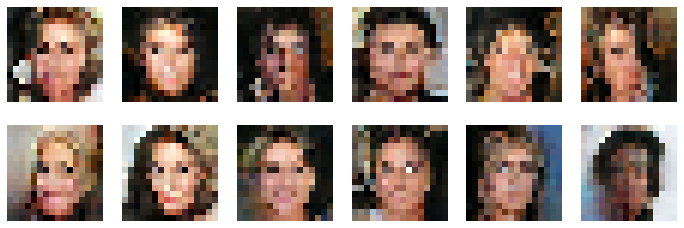

image name ./save_images/res_16x16_0.jpg
alpha [[1.]]
elapsed 7 min 57 sec
STABLE. Resolution 16x16 Step 4000: g_loss 1.8634 d_loss -2.2542
Saving checkpoint ./checkpoints/ckpt-22


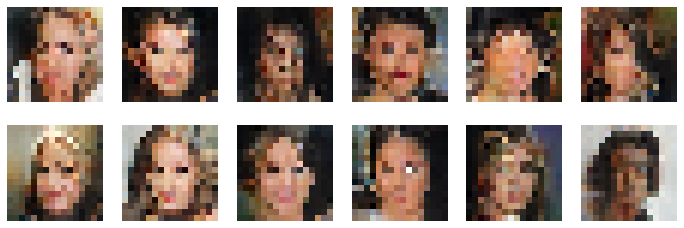

image name ./save_images/res_16x16_4000.jpg
alpha [[1.]]
elapsed 7 min 57 sec
STABLE. Resolution 16x16 Step 8000: g_loss 36.2715 d_loss -3.0296
Saving checkpoint ./checkpoints/ckpt-23


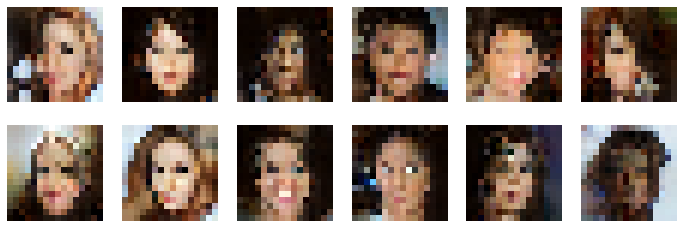

image name ./save_images/res_16x16_8000.jpg
alpha [[1.]]
elapsed 7 min 58 sec
STABLE. Resolution 16x16 Step 12000: g_loss -3.0832 d_loss 2.0740
Saving checkpoint ./checkpoints/ckpt-24


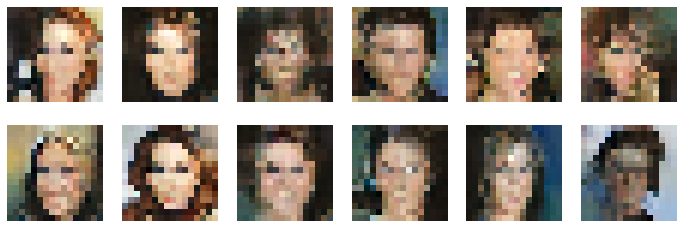

image name ./save_images/res_16x16_12000.jpg
alpha [[1.]]
elapsed 7 min 58 sec
STABLE. Resolution 16x16 Step 16000: g_loss -35.5651 d_loss -0.6232
Saving checkpoint ./checkpoints/ckpt-25


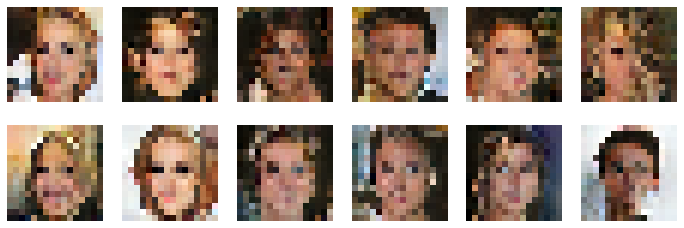

image name ./save_images/res_16x16_16000.jpg
Growing model to 256x256
Resolution 32x32
alpha [[0.]]
elapsed 0 min 0 sec
TRANSITION. Resolution 32x32 Step 0: g_loss -3.9508 d_loss -1.0625
Saving checkpoint ./checkpoints/ckpt-26


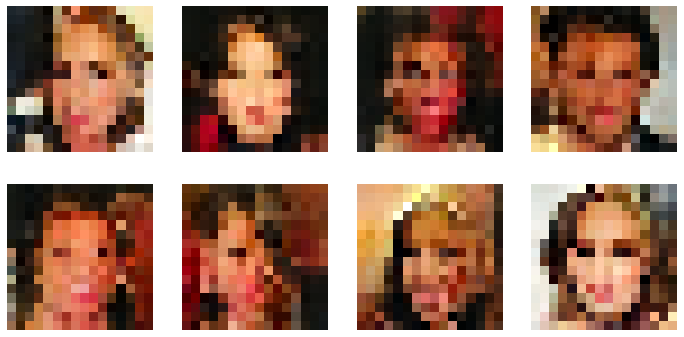

image name ./save_images/res_32x32_0.jpg
alpha [[0.2]]
elapsed 16 min 39 sec
TRANSITION. Resolution 32x32 Step 4000: g_loss 7.8841 d_loss -0.4717
Saving checkpoint ./checkpoints/ckpt-27


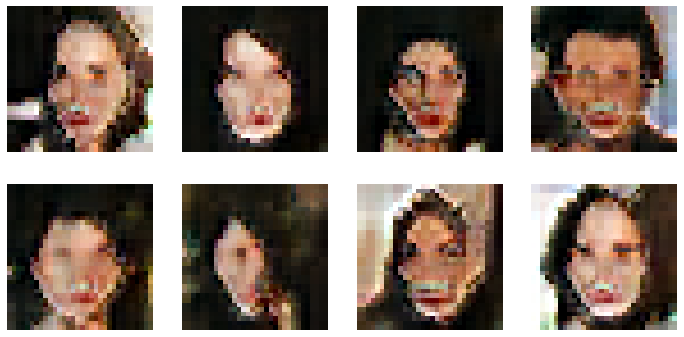

image name ./save_images/res_32x32_4000.jpg
alpha [[0.4]]
elapsed 16 min 38 sec
TRANSITION. Resolution 32x32 Step 8000: g_loss -13.5485 d_loss -3.8829
Saving checkpoint ./checkpoints/ckpt-28


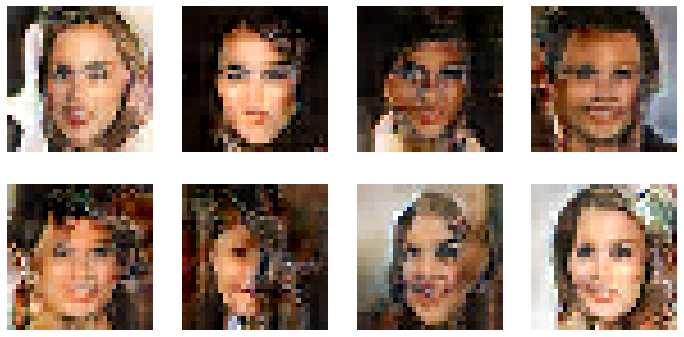

image name ./save_images/res_32x32_8000.jpg
alpha [[0.6]]
elapsed 16 min 37 sec
TRANSITION. Resolution 32x32 Step 12000: g_loss 24.9111 d_loss -2.3035
Saving checkpoint ./checkpoints/ckpt-29


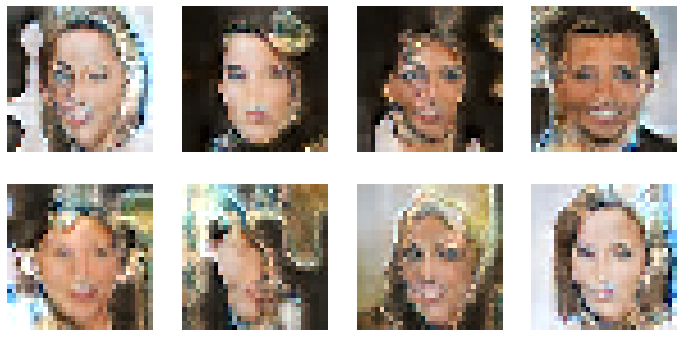

image name ./save_images/res_32x32_12000.jpg
alpha [[0.8]]
elapsed 16 min 37 sec
TRANSITION. Resolution 32x32 Step 16000: g_loss 6.9890 d_loss 0.1351
Saving checkpoint ./checkpoints/ckpt-30


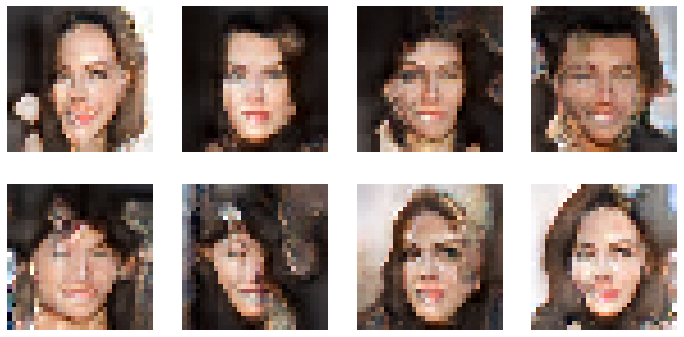

image name ./save_images/res_32x32_16000.jpg
alpha [[1.]]
elapsed 16 min 37 sec
STABLE. Resolution 32x32 Step 0: g_loss 0.7824 d_loss 0.2118
Saving checkpoint ./checkpoints/ckpt-31


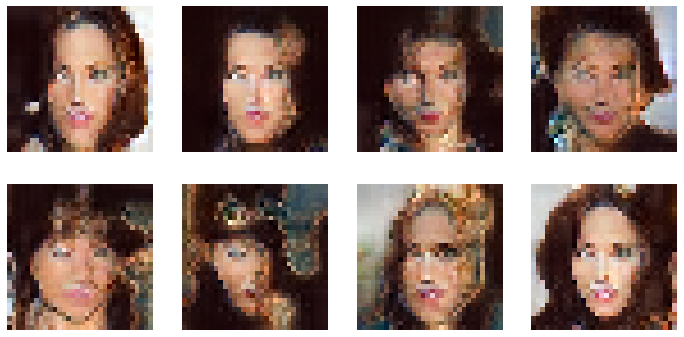

image name ./save_images/res_32x32_0.jpg
alpha [[1.]]
elapsed 16 min 37 sec
STABLE. Resolution 32x32 Step 4000: g_loss 2.8459 d_loss 2.7309
Saving checkpoint ./checkpoints/ckpt-32


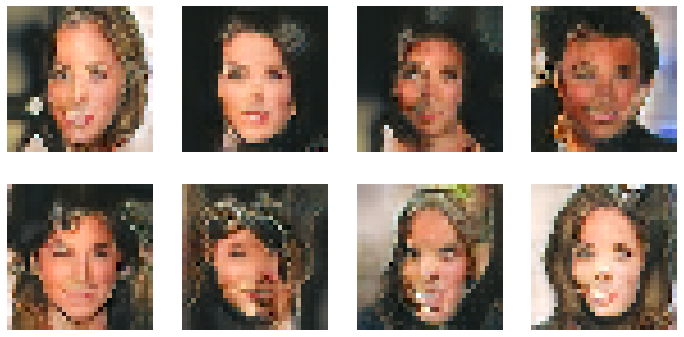

image name ./save_images/res_32x32_4000.jpg
alpha [[1.]]
elapsed 16 min 37 sec
STABLE. Resolution 32x32 Step 8000: g_loss -1.9296 d_loss 1.5148
Saving checkpoint ./checkpoints/ckpt-33


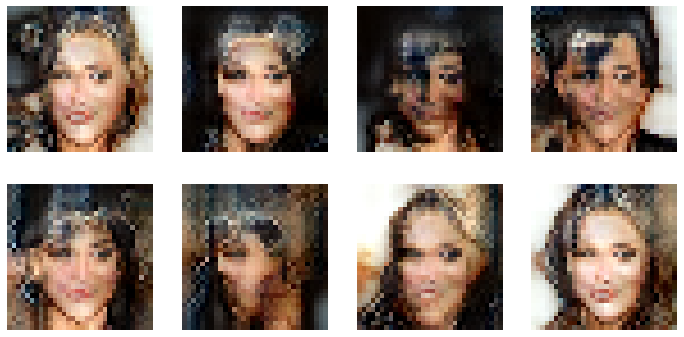

image name ./save_images/res_32x32_8000.jpg
alpha [[1.]]
elapsed 16 min 37 sec
STABLE. Resolution 32x32 Step 12000: g_loss -3.9510 d_loss -0.2920
Saving checkpoint ./checkpoints/ckpt-34


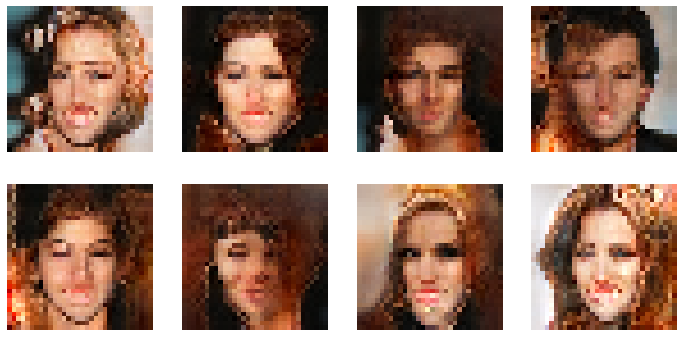

image name ./save_images/res_32x32_12000.jpg
alpha [[1.]]
elapsed 16 min 38 sec
STABLE. Resolution 32x32 Step 16000: g_loss -1.6934 d_loss 3.2011
Saving checkpoint ./checkpoints/ckpt-35


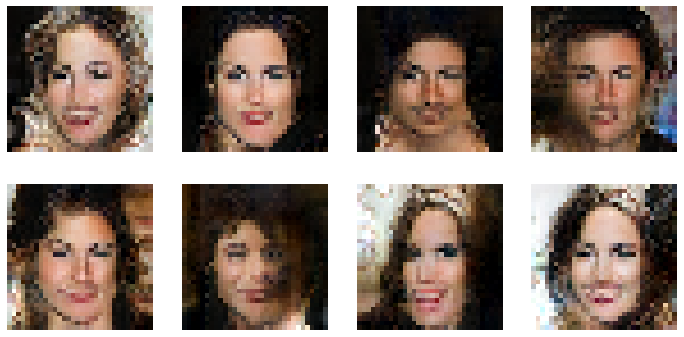

image name ./save_images/res_32x32_16000.jpg
Growing model to 256x256
Resolution 64x64
alpha [[0.]]
elapsed 0 min 0 sec
TRANSITION. Resolution 64x64 Step 0: g_loss 3.1311 d_loss 3.9317
Saving checkpoint ./checkpoints/ckpt-36


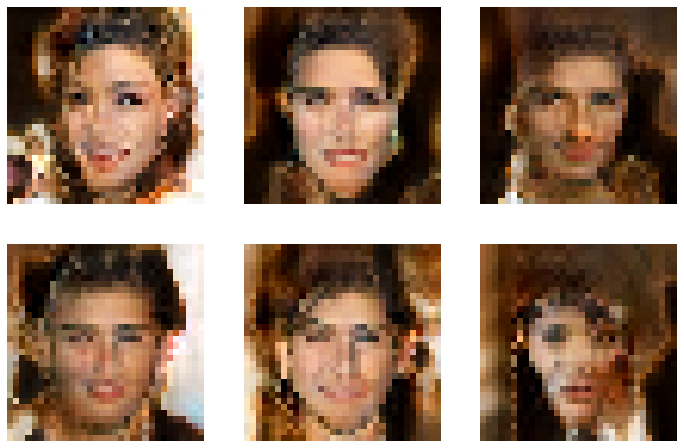

image name ./save_images/res_64x64_0.jpg
alpha [[0.2]]
elapsed 33 min 39 sec
TRANSITION. Resolution 64x64 Step 4000: g_loss 0.8245 d_loss 1.7440
Saving checkpoint ./checkpoints/ckpt-37


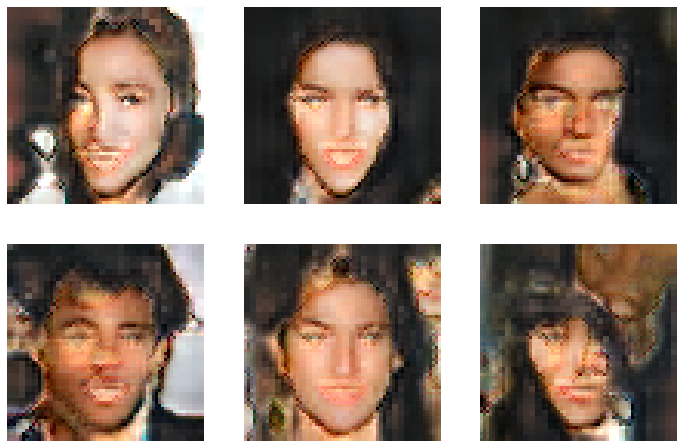

image name ./save_images/res_64x64_4000.jpg
alpha [[0.4]]
elapsed 33 min 37 sec
TRANSITION. Resolution 64x64 Step 8000: g_loss -8.0423 d_loss -4.6390
Saving checkpoint ./checkpoints/ckpt-38


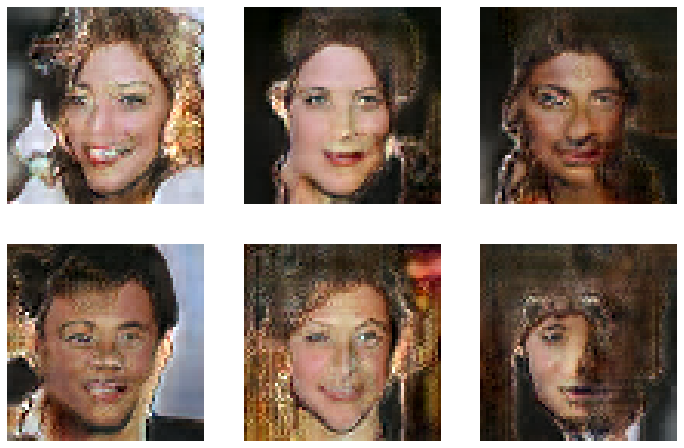

image name ./save_images/res_64x64_8000.jpg
alpha [[0.6]]
elapsed 33 min 37 sec
TRANSITION. Resolution 64x64 Step 12000: g_loss -50.2561 d_loss -4.1155
Saving checkpoint ./checkpoints/ckpt-39


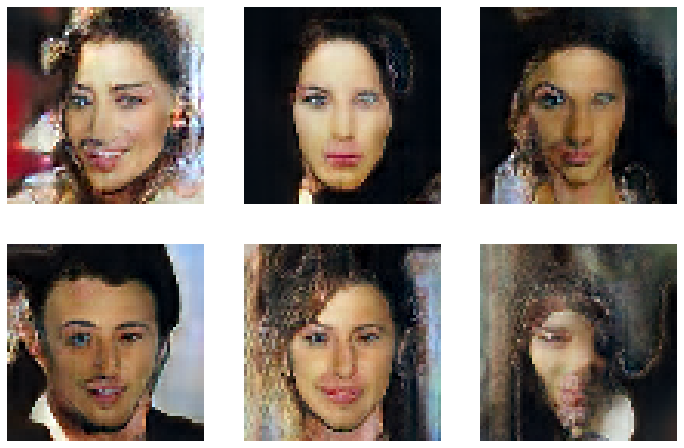

image name ./save_images/res_64x64_12000.jpg
alpha [[0.8]]
elapsed 33 min 36 sec
TRANSITION. Resolution 64x64 Step 16000: g_loss 5.1730 d_loss -1.7422
Saving checkpoint ./checkpoints/ckpt-40


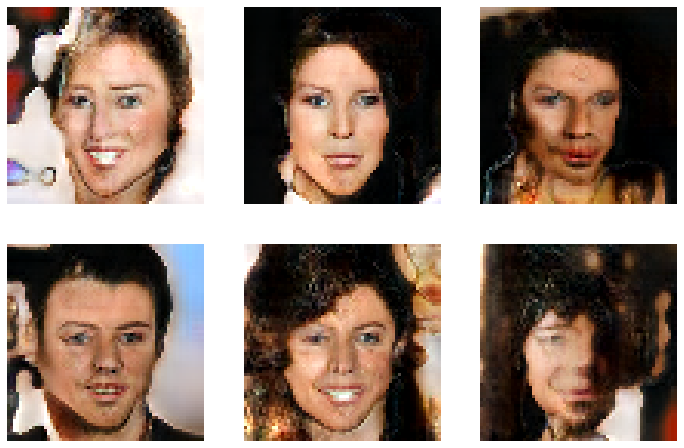

image name ./save_images/res_64x64_16000.jpg
alpha [[1.]]
elapsed 33 min 36 sec
STABLE. Resolution 64x64 Step 0: g_loss 3.6528 d_loss 6.7669
Saving checkpoint ./checkpoints/ckpt-41


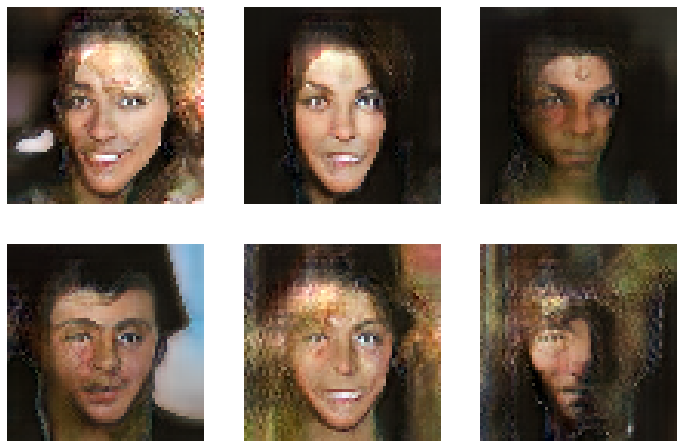

image name ./save_images/res_64x64_0.jpg
alpha [[1.]]
elapsed 33 min 36 sec
STABLE. Resolution 64x64 Step 4000: g_loss 10.3303 d_loss -1.5850
Saving checkpoint ./checkpoints/ckpt-42


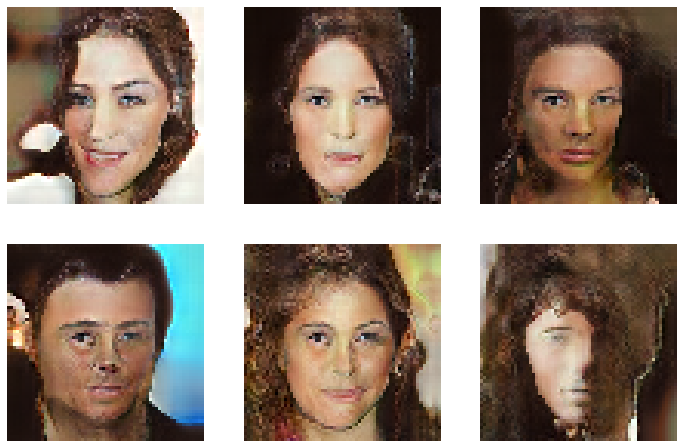

image name ./save_images/res_64x64_4000.jpg
alpha [[1.]]
elapsed 33 min 35 sec
STABLE. Resolution 64x64 Step 8000: g_loss 22.6701 d_loss -1.5068
Saving checkpoint ./checkpoints/ckpt-43


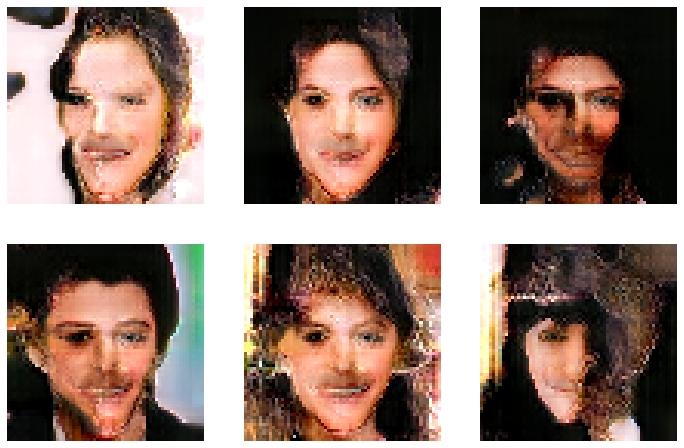

image name ./save_images/res_64x64_8000.jpg
alpha [[1.]]
elapsed 33 min 35 sec
STABLE. Resolution 64x64 Step 12000: g_loss -5.6633 d_loss 4.6082
Saving checkpoint ./checkpoints/ckpt-44


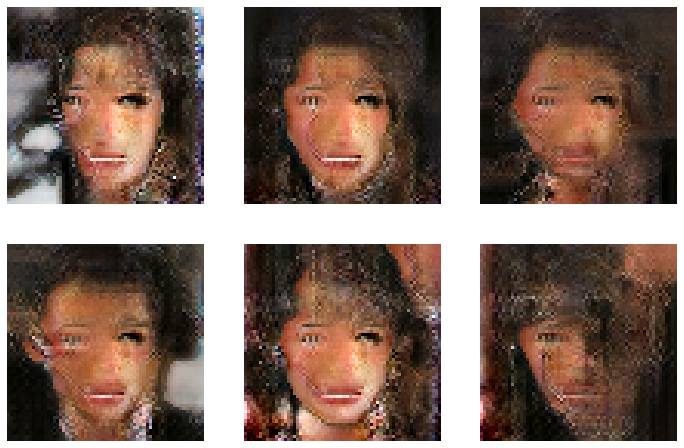

image name ./save_images/res_64x64_12000.jpg
alpha [[1.]]
elapsed 33 min 34 sec
STABLE. Resolution 64x64 Step 16000: g_loss 14.5004 d_loss -0.8256
Saving checkpoint ./checkpoints/ckpt-45


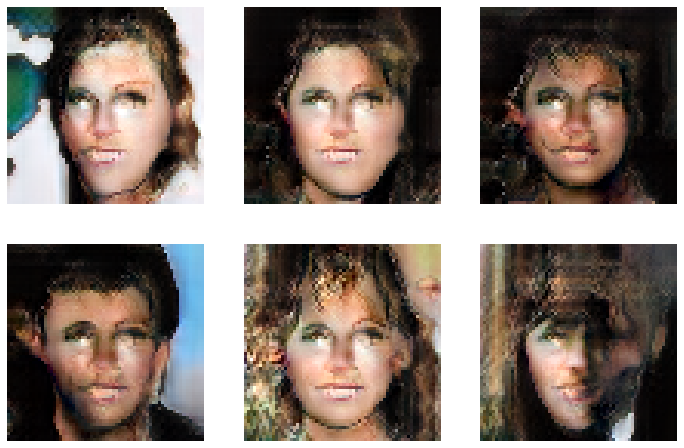

image name ./save_images/res_64x64_16000.jpg
Growing model to 256x256
Resolution 128x128
alpha [[0.]]
elapsed 0 min 0 sec
TRANSITION. Resolution 128x128 Step 0: g_loss 18.9987 d_loss 4.7176
Saving checkpoint ./checkpoints/ckpt-46


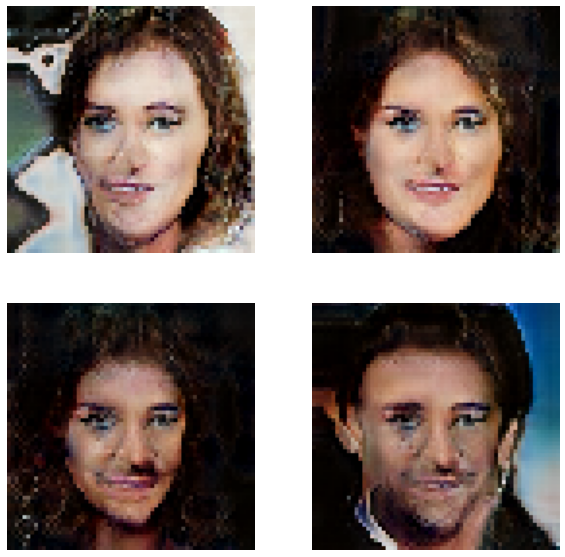

image name ./save_images/res_128x128_0.jpg


ResourceExhaustedError: OOM when allocating tensor with shape[16,512,18,18] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2DBackpropInput]

In [23]:
gan.train(train_datasets, 20000, 4000)

In [ ]:
for i in range(2, 9):
    gan.to_rgb[i].save(f'saved_model/to_rgb_{i}')
    gan.from_rgb[i].save(f'saved_model/from_rgb_{i}')
    gan.discriminator_blocks[i].save(f'saved_model/d_{i}')
    gan.generator_blocks[i].save(f'saved_model/g_{i}')

In [ ]:
tf.keras.utils.plot_model(gan.discriminator, show_shapes=True)

In [ ]:
tf.keras.utils.plot_model(gan.generator, show_shapes=True)

In [ ]:
tf.keras.utils.plot_model(gan.model, show_shapes=True)

# Inference

In [ ]:
path  = 'saved_model'
for i in range(2, 9):
    gan.to_rgb[i] = load_model(f'{path}/to_rgb_{i}')
    gan.from_rgb[i]= load_model(f'{path}/from_rgb_{i}')
    gan.discriminator_blocks[i]= load_model(f'{path}/d_{i}')
    gan.generator_blocks[i]= load_model(f'{path}/g_{i}')

In [ ]:
log2_res = 7
gan.grow_model(log2_res)

In [ ]:
gan.alpha = [[1.]]
z = tf.random.normal((12, 512))
images = gan.generate(z)
plot_images(images, log2_res)